# **Libraries Preparation**

In [4]:
# For technical analysis indicators
!pip install ta

It is a Technical Analysis library for financial data, it is maintained by Dario Lopez Padial.

https://pypi.org/project/ta/

In [5]:
# For portfolio optimization tools
!pip install PyPortfolioOpt

"PyPortfolioOpt is a library that implements portfolio optimization methods, including classical mean-variance optimization techniques and Black-Litterman allocation"

https://pypi.org/project/pyportfolioopt/

In [6]:
# Import useful libraries for data handling.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Import metrics to evaluate prediction model performance
from sklearn.metrics import mean_squared_error, r2_score

# CVXPY is used for convex optimization problem
import cvxpy as cvx

import pandas_datareader.data as web
import datetime

# Library with returns forecasting models
from PredictionModels import *



# Import library to fetch stock price data from Yahoo Finance
import yfinance as yf
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

# **Data Preparation**

In [8]:
# List of asset tickers

tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 2101,
    'MA': 532,
    'ETH-USD': 307,
    'KO': 309,
    'BAC': 337,
    'GE': 250,
    'ADBE': 179,
    'MCD': 227,
    'DIS.MX': 202,
    'PEP': 180,
    'CVX': 239
}

# Start of historical price data
start_date = '2018-01-01'
# End of historical price data
end_date = '2025-04-20'
period = '1d'

Before we are going to build our portfolio, we selected a mix between cryptocurrencies and stocks across sectors and industries.

Start Date : 2018/01/01

End Date : 2025/04/20

We selected :

Cryptocurrencies
* Bitcoin

Bitcoin is the first decentralized cryptocurrency. Bitcoin was invented in 2008.

* Etherium

Ethereum is a decentralized blockchain with smart contract functionality. ETH is second biggest in market capitalization in cryptocurrency market.

Financials
* Mastercard
* Bank of America

Consumer Goods & Services
* Coca-Cola
* Pepsico
* McDonald
* The Walt Disney Company


Industrials
* General Electric

Technology
* Adobe

Energy
* Chevron


For cryptocurrencies, we selected Bitcoin and Ethereum because they are the top two by market capitalization and have long historical data available, making them suitable for portfolio analysis.

To diversify the portfolio, we selected assets from different sectors, including Financials, Consumer Goods, Services, Industrials, Technology, and Energy.



# **Building for Benchmark Markowitz**

In [9]:
class Markowitz(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps = caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)
        self.exp_returns = self.data[1].mean() * 252 # If we have daily data
        self.cov = self.data[1].cov() * 252
        self.length = self.exp_returns.shape[0]
    def optimize(self):
        """
        The function optimizes the weights using Markowitz approach
        The function returns optimized weights for Markowitz portfolio
        """
        Q = np.array(self.cov)
        q = np.array(self.exp_returns)
        # Inequalities are written as Gx <= h
        G = np.diag(-1*np.ones(self.length), 0)
        h = np.zeros(self.length, dtype=int)
        # Equality constraints are written as Ax == b
        A = np.ones(self.length, dtype=int)
        b = np.array([1])
        # Defining and solving the quandratic problem
        x = cvx.Variable(self.length)
        prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x),
            [G @ x <= h, A @ x == b])
        prob.solve()

        # Retrieving the weights
        x_values = x.value
        w = dict()
        for i in range(self.length):
            w[self.tickers[i]] = round(x_values[i], 4)

        return w

    def plot_weights(self):
        weights = self.optimize()
        fig = plt.figure(figsize=(15,5))
        plt.bar(weights.keys(), weights.values(), color='b', width=0.7)
        plt.title("Asset allocation by Markowitz model", y=1.05)
        plt.xlabel("Investment assets")
        plt.ylabel("Weights of assets in Markowitz portfolio")
        plt.grid()
        plt.show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


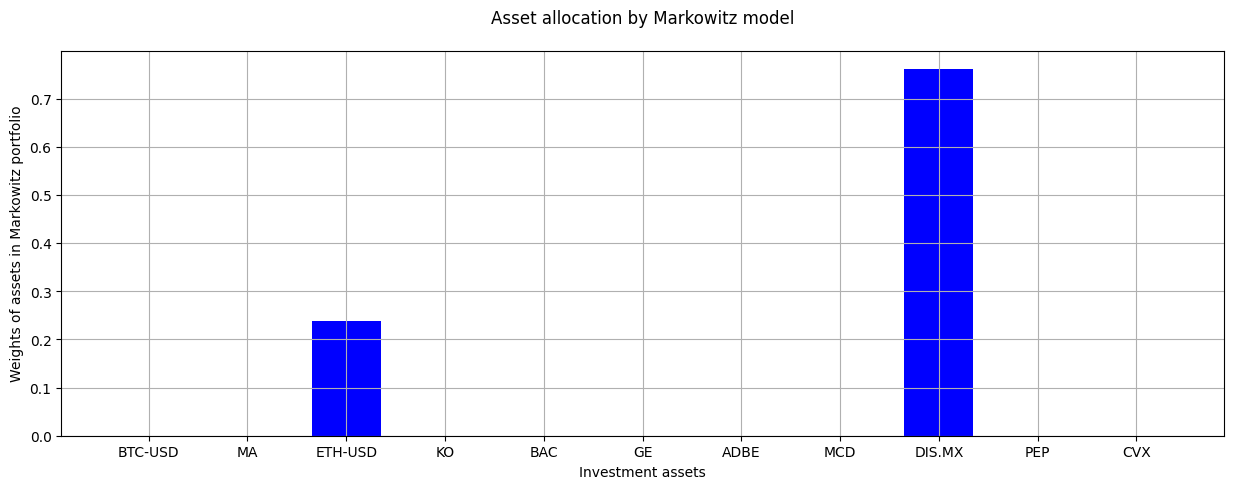

In [10]:
# Instantiate the Markowitz model with given tickers, date range, frequency, and market caps
markowitz_model = Markowitz(tickers=tickers, start_date=start_date, end_date=end_date, period=period, caps=caps)
opt_weights = markowitz_model.optimize()
# Plot the resulting portfolio weights as a bar chart
markowitz_model.plot_weights()

As you can see, the bar charts shows us the optimal portfolio weights for 11 assets by using Markowitz mean-variance optimization model.

Insights:

*   ETH received allocation around 25% while Disney received around 75%
*   The rest assets received 0% of allocation
*   Disney has low volatility during the time window, so that Markowitz put heaviliy weight on this stock



# **Build BlackLitterman Function**

We built Blacklitterman and consolidate prediction returns by using 10 models



* **Decision Tree Regressor**

Decision Tree Regressor is a non-parametric supervised learning. It splits the data into subsets based on feature values to predict a continuous outcome. In finance, decision tree has been widely used.  

* **LinearRegressionPredictor**

Linear Regression can provide us linear relationship between our independent variable and our target so that we can predict the probability of the outcome. Key benefits of linear regression are easy for interpretability and implement.  

* **Support Vector Regression**

SVR is an extension of SVM (Support Vector Machines) built for regression tasks. One of key strengths is to identify a function that fits data while keeping prediction errors as small as possible.


* **LSTMPredictor**

LSTM or Long Short-Term Memory is a better version of RNN. LSTM has ability to  capture “long-term dependencies in sequential data,” so it is suitable for tasks such as time series forecasting.  

* **CNNPredictor**

A Convolutional Neural Network is a deep learning algorithm originally developed for processing visual data, such as images and videos. However, in the financial world, CNN have been successfully adapted to analyze structured data by treating time series or financial indicators as visual patterns. CNN can be used to detect patterns in stock price movements.

* **TransformerPredictor**

Transformer can be applied to model complex sequences in time-series data, such as stock prices. Transformers use self-attention to capture long-range dependencies and relationships across entire sequences simultaneously.


* **XGBoost**

XGBoost is a powerful machine learning tool for scalability and efficiency. Its strength is its ability to handle large datasets. XGBoost optimizes a regularized loss function, which helps prevent overfitting, and XGBoost can also handle missing values.

* **MLPPredictor**

MLP or Multi-Layer Perceptron is a neural network. In MLP, there are multiple layers,  and its connected. MLP has an input layer, one or more hidden layers, and an output layer. MLP is very useful for pattern recognition or time series forecasting.

* **RidgeRegressionPredictor**

Ridge regression is a technique used to address overfitting in linear regression models. In general, it helps improve a model’s performance by reducing error. Ridge Regression is especially useful when dealing with multicollinearity.

* **WeightedAverageEnsemble**


Weight Model Averaging, often referred to simply as model averaging, is a machine learning technique that combines the predictions of multiple models to generate a single, more reliable output rather than selecting only one model. This approach assigns weights to each model according to its performance.

In [11]:
class BlackLitterman(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps=caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)

        # Loading additional data of 3-month US treasure rates to calculate excess returns
        self.tickers = tickers
        self.start_date = start_date
        self.end_data = end_date
        self.t_rates = web.DataReader("TB3MS", 'fred', start=self.start_date, end=self.end_date)
        self.t_rates.reset_index(inplace=True)
        self.t_rates.rename(columns={"DATE": "Date"}, inplace=True)
        self.t_rates['TB3MS'] = self.t_rates['TB3MS'] / 100
        self.data[1].reset_index(inplace=True)
        print(self.data[1])

        # Merging the assets data and T-bill data
        self.full_data = pd.merge(self.data[1], self.t_rates, how='left', on='Date')
        # Filling in the gaps
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(0.0015)
        # Converting the rates into 1 day rate by dividing by 90 days
        self.full_data['TB3MS'] = self.full_data['TB3MS'] / 90

        # Dividing the data into treasury returns and other assets returns
        self.assets_returns = self.full_data[self.tickers]
        self.treasury_rate = self.full_data["TB3MS"]

    def equil_weights(self):
        """
            The function returns equilibrium weights calculated using market capitalization of assets (Yahoo Finance)
        """
        asset_weights = pd.DataFrame(self.caps.values(), index=self.caps.keys(), columns=['Cap'])
        asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
        return asset_weights

    def implied_equil_returns(self):
        """
        Calculates implied equilibrium excess returns based on market weights and risk aversion.
        """
        assets_weights = self.equil_weights()
        excess_returns = self.assets_returns.subtract(self.treasury_rate, axis=0)
        # Calculation of excess returns covariance matrix
        covar = excess_returns.cov() * 252
                # Risk-aversion parameter
        risk_aversion = 10
        print("risk_aversion=",risk_aversion)

        return self.implied_function(risk_aversion, covar, assets_weights['Weights'])


    def implied_function(self, risk_avers_param, sig, weights):
        """
            The function calculates equlibrium market returns

            Arg:
                - risk_avers_param (float) - risk-aversion parameter
                - sig (np.array) - covariance matrix of excess returns
                - weights (pd.Series) - equilibrium market weights
            return: equlibrium market returns
        """

        return risk_avers_param * sig.dot(weights).squeeze()


    def views_function(self):
        pass

    def function(self, predictions: dict, method: str):
        """
        The function returns the views matrix based on predictions
        """
        pass


    def function1(self):
        """
        The function does some!
        """

        pass


    def consolid_preds(self):
        """
        The function stores expected returns for each asset based on different models predictions
        """
        self.q_matrix = np.zeros(len(self.tickers))

        # Container of forecasts
        preds = np.zeros((10, len(self.tickers)))

        for i, ticker in enumerate(self.tickers):
            # Initializing the prediction models

            # DesicionTreeRegressor
            des_tree = DesicionTreeRegressorPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )
            # LogisticRegression
            log_reg = LinearRegressionPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )
            #	Support Vector Regression
            svr_reg = SVRPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )


            lstm_reg = LSTMPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )


            cnn_reg = CNNPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )
            #TransformerPredictor
            tf_reg = TransformerPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            xgb_reg = XGBoostPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            mlp_reg = MLPPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )
            #RidgeRegressionPredictor
            rr_reg = RidgeRegressionPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )
            #WeightedAverageEnsemble
            wae_reg = WeightedAverageEnsemble(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            # Making forecasts
            preds[0, i] = des_tree.make_forecast()[0]
            preds[1, i] = log_reg.make_forecast()[0]
            preds[2, i] = svr_reg.make_forecast()[0]
            preds[3, i] = lstm_reg.make_forecast()[0]
            preds[4, i] = cnn_reg.make_forecast()[0]

            preds[5, i] = tf_reg.make_forecast()[0]
            preds[6, i] = xgb_reg.make_forecast()[0]
            preds[7, i] = mlp_reg.make_forecast()[0]
            preds[8, i] = rr_reg.make_forecast()[0]
            preds[9, i] = wae_reg.make_forecast()[0]




        return preds



In [26]:
data = data.round(4)
data

Ticker,ADBE,BAC,BTC-USD,CVX,DIS.MX,ETH-USD,GE,KO,MA,MCD,PEP
Date,,,,,,,,,,,
2018-01-01,NaN,NaN,13657.2002,NaN,NaN,772.6410,NaN,NaN,NaN,NaN,NaN
2018-01-02,177.70,25.0441,14982.0996,92.3530,2152.6511,884.4440,81.4831,36.2722,145.6647,145.2608,94.2381
2018-01-03,181.04,24.9603,15201.0000,93.0262,2163.9773,962.7200,82.2535,36.1926,147.4961,144.6486,93.9906
2018-01-04,183.22,25.2870,15599.2002,92.7367,2162.4805,980.9220,83.9756,36.7023,149.4044,145.6633,94.4536
2018-01-05,185.34,25.4042,17429.5000,92.5846,2137.5325,997.7200,84.0209,36.6944,152.5016,145.9568,94.7250
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15,350.38,37.7674,83668.9922,132.9210,1708.0000,1588.6324,185.6700,71.8600,517.3800,310.7177,141.2897
2025-04-16,344.19,37.1113,84033.8672,133.7311,1650.2700,1578.1053,182.4500,71.6800,513.4300,307.3568,138.5695
2025-04-17,348.80,37.1908,84895.7500,136.2109,NaN,1582.5483,181.7900,73.0000,517.3300,309.5444,141.2897


# **Build Black-Litterman for Benchmark**

For the features we used to build models are:



*   **Lagged Return**
*   **Technical indicators: SMA, EMA, RSI, MACD**


*      **Simple Moving Average**

SMA is a useful tool used in time-series analysis in financial market. It calculates average of a selected range of prices by the number of periods in that range. SMA can be used to identify trend direction, and trading signals.

*      **Exponential Moving Average**

EMA is a enhance version of SMA that gives more weight to recent data points makes it to be more responsive to new information. EMA is used to detect momentum shifts, trend confirmation.  

*      **Relative Strength Index**

RSI is a technical indicator used for determining the momentum of any asset’s price. It can help to identify potential overbought or oversold areas. RSI is a range between 0 and 100, where a range above 70 indicates overbought, and a range below 30 indicates oversold.


*     **Moving Average Convergence Divergence**

MACD is a technical indicator used for the trend strength of the price of an asset. MACD captures both trend-following and momentum characteristics.



In [ ]:
tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 2101,
    'MA': 532,
    'ETH-USD': 307,
    'KO': 309,
    'BAC': 337,
    'GE': 250,
    'ADBE': 179,
    'MCD': 227,
    'DIS.MX': 202,
    'PEP': 180,
    'CVX': 239
}
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

bl = BlackLitterman(tickers, start_date, end_date, period)
# Generate consolidated return predictions from all models
forecasts = bl.consolid_preds()
# Compute the mean predicted return for each ticker across all models (used as "views")
mean_preds = forecasts.mean(axis=0)
# Assign the mean predictions to a pandas Series Q, indexed by ticker names (the "view" vector)
Q = pd.Series(mean_preds, index=tickers)

# Scale the predicted returns down (e.g., for more conservative views)
Q = Q * 0.5


P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)

# Estimate the annualized covariance matrix of asset returns (S)
S           = bl.assets_returns.cov() * 252
# Calculate implied equilibrium returns
prior       = bl.implied_equil_returns()   # π
# Set confidence levels for each view
confidences = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]






# Creating model
bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


rets = bl2.bl_returns() # Calculating Expected returns
ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
weights1 = ef.clean_weights() # Cleaning weights
weights1 # Printing weights

[*********************100%***********************]  11 of 11 completed
<ipython-input-13-609006600094>:35: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


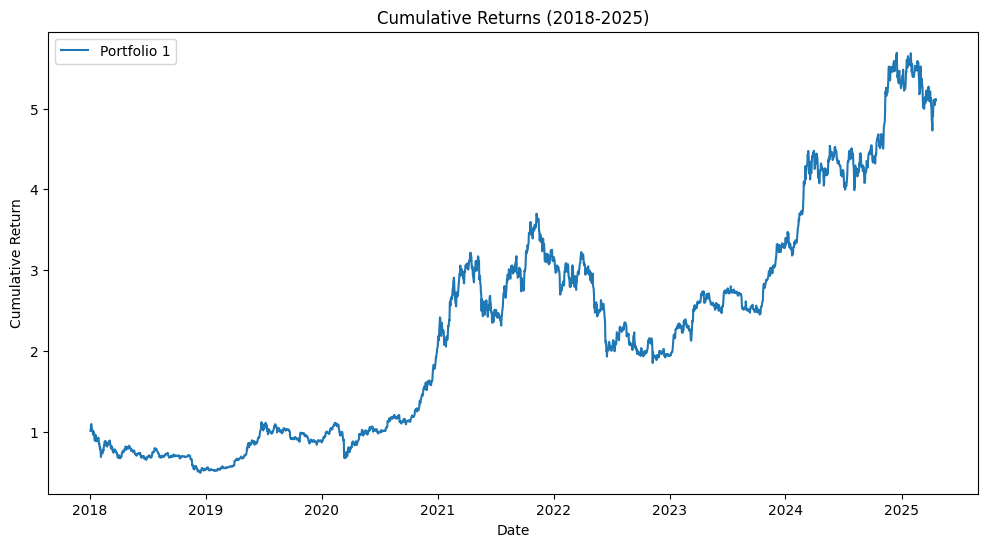

In [13]:
# Define the portfolios
portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]





# Download historical data from Yahoo Finance
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'
portfolios = {'Portfolio 1': portfolio1}

# Fetch weekly adjusted close prices
weekly_data = {}
for name, tickers in portfolios.items():
    data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
    weekly_data[name] = data


prices_portfolio1 = weekly_data['Portfolio 1']

returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Portfolio 1'] = (1 + returns_portfolio1).cumprod()


# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

**Backtesting and Test Several Strategies for Opmitizing Portfolio 3 Months, 6 Months, and 12 Months Rebalancing**

We built backtesting and test several strategies for opmitizing portfolio 3 Months, 6 Months, and 12 Months

In [ ]:
weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='3M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}
returns_portfolio = {}
returns_portfolio_2_ = {}
returns_portfolio_3_ = {}
returns_portfolio_4_ = {}
for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)

# Step 1: Fit Black-Litterman model
  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

# Step 2: Apply weights to next period
    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs2 = [returns_portfolio[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# # Concatenate them side by side (columns)
combined_df2 = pd.concat(dfs2, axis=0)



# #4 Months -----------


# weekly_dates = pd.date_range(
#     start='2018-01-01',
#     end='2025-04-20',
#     freq='4M'
# ).strftime('%Y-%m-%d').tolist()


# i = 0
# prices_portfolio = {}

# for k in range(len(weekly_dates) - 2):

#   i = i + 1
#   tickers = [
#     'BTC-USD', # Bitcoin
#     'MA', # Mastercard
#     'ETH-USD', # Etherium
#     'KO', # Coca-Cola
#     'BAC', # Bank of America
#     'GE', # General Electric
#     'ADBE', # Adobe
#     'MCD', # McDonald
#     'DIS.MX', # The Walt Disney Company
#     'PEP', # Pepsico
#     'CVX', # Chevron
# ]


#   start_date = weekly_dates[k]
#   end_date = weekly_dates[k+1]
#   period = '1d'

#   print(start_date,end_date)


#   bl = BlackLitterman(tickers, start_date, end_date, period)

#   forecasts = bl.consolid_preds()
#   mean_preds = forecasts.mean(axis=0)
#   Q = pd.Series(mean_preds, index=tickers)

#   Q = Q * 0.5

#   P = pd.DataFrame(
#     np.eye(len(tickers)),
#     index=tickers,
#     columns=tickers
# )


#   S           = bl.assets_returns.cov() * 252
#   prior       = bl.implied_equil_returns()   # π
#   confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# # Creating model
#   bl2 = BlackLittermanModel(S, # Covariance Matrix
#                          pi = prior, # Prior expected returns
#                          Q = Q, # Vector of views
#                          P = P, # Matrix mapping the views
#                          omega = 'idzorek', # Confidence levels in %
#                          view_confidences = confidences) # Confidences


#   rets = bl2.bl_returns() # Calculating Expected returns
#   ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

#   ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
#   weights1 = ef.clean_weights() # Cleaning weights
#   weights1 # Printing weights

#     # Define the portfolios
#   portfolio1 = [
#     'BTC-USD', # Bitcoin
#     'MA', # Mastercard
#     'ETH-USD', # Etherium
#     'KO', # Coca-Cola
#     'BAC', # Bank of America
#     'GE', # General Electric
#     'XOM', # Exxon Mobil Corporation
#     'MCD', # McDonald
#     'DIS.MX', # The Walt Disney Company
#     'PG.MX', # The Procter & Gamble Company
#     'CVX' # Chevron
# ]
#   # Download historical data from Yahoo Finance
#   start_date = weekly_dates[k+1]
#   end_date = weekly_dates[k+2]
#   period = '1d'
#   portfolios = {'Portfolio 1': portfolio1}


#   # Fetch weekly adjusted close prices
#   weekly_data = {}
#   for name, tickers in portfolios.items():
#       data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
#       weekly_data[name] = data

#   prices_portfolio = weekly_data['Portfolio 1']
#   returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)

# dfs3 = [returns_portfolio_2_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# # Concatenate them side by side (columns)
# combined_df3 = pd.concat(dfs3, axis=0)



# #5 Months -----------


# weekly_dates = pd.date_range(
#     start='2018-01-01',
#     end='2025-04-20',
#     freq='5M'
# ).strftime('%Y-%m-%d').tolist()


# i = 0
# prices_portfolio = {}

# for k in range(len(weekly_dates) - 2):

#   i = i + 1
#   tickers = [
#     'BTC-USD', # Bitcoin
#     'MA', # Mastercard
#     'ETH-USD', # Etherium
#     'KO', # Coca-Cola
#     'BAC', # Bank of America
#     'GE', # General Electric
#     'ADBE', # Adobe
#     'MCD', # McDonald
#     'DIS.MX', # The Walt Disney Company
#     'PEP', # Pepsico
#     'CVX', # Chevron
# ]


#   start_date = weekly_dates[k]
#   end_date = weekly_dates[k+1]
#   period = '1d'

#   print(start_date,end_date)


#   bl = BlackLitterman(tickers, start_date, end_date, period)

#   forecasts = bl.consolid_preds()
#   mean_preds = forecasts.mean(axis=0)
#   Q = pd.Series(mean_preds, index=tickers)

#   Q = Q * 0.5

#   P = pd.DataFrame(
#     np.eye(len(tickers)),
#     index=tickers,
#     columns=tickers
# )


#   S           = bl.assets_returns.cov() * 252
#   prior       = bl.implied_equil_returns()   # π
#   confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# # Creating model
#   bl2 = BlackLittermanModel(S, # Covariance Matrix
#                          pi = prior, # Prior expected returns
#                          Q = Q, # Vector of views
#                          P = P, # Matrix mapping the views
#                          omega = 'idzorek', # Confidence levels in %
#                          view_confidences = confidences) # Confidences


#   rets = bl2.bl_returns() # Calculating Expected returns
#   ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

#   ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
#   weights1 = ef.clean_weights() # Cleaning weights
#   weights1 # Printing weights

#     # Define the portfolios
#   portfolio1 = [
#     'BTC-USD', # Bitcoin
#     'MA', # Mastercard
#     'ETH-USD', # Etherium
#     'KO', # Coca-Cola
#     'BAC', # Bank of America
#     'GE', # General Electric
#     'XOM', # Exxon Mobil Corporation
#     'MCD', # McDonald
#     'DIS.MX', # The Walt Disney Company
#     'PG.MX', # The Procter & Gamble Company
#     'CVX' # Chevron
# ]
#   # Download historical data from Yahoo Finance
#   start_date = weekly_dates[k+1]
#   end_date = weekly_dates[k+2]
#   period = '1d'
#   portfolios = {'Portfolio 1': portfolio1}


#   # Fetch weekly adjusted close prices
#   weekly_data = {}
#   for name, tickers in portfolios.items():
#       data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
#       weekly_data[name] = data

#   prices_portfolio = weekly_data['Portfolio 1']
#   returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)




# dfs4 = [returns_portfolio_3_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# # Concatenate them side by side (columns)
# combined_df4 = pd.concat(dfs4, axis=0)


#6 Months -----------


weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='6M'
).strftime('%Y-%m-%d').tolist()


i = 0


# We use (len(weekly_dates) - 2) in the loop because:
# - The last date in weekly_dates is close to or at the end date (2025-04-20).
# - We want to make a prediction for a period before the final interval ends,
#   so we exclude the last interval (can't make a prediction that needs data after 2025-04-20).
# - The second-to-last index (i.e., -2) ensures predictions use only available data.

for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)

# Estimate the annualized covariance matrix of asset returns (S)
  S           = bl.assets_returns.cov() * 252
# Calculate implied equilibrium returns
  prior       = bl.implied_equil_returns()   # π
# Set confidence levels for each view (here, 0.5 for all assets)
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs5 = [returns_portfolio_4_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# Concatenate them side by side (columns)
combined_df5 = pd.concat(dfs5, axis=0)




#12 Months -----------


weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='12M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}
returns_portfolio_5_= {}
for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs6 = [returns_portfolio_5_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# Concatenate them side by side (columns)
combined_df6 = pd.concat(dfs6, axis=0)

# **Prepare for Back Testing**

In [18]:
# Define the portfolios
portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


# Convert the optimized weights (from Markowitz model) to float values for calculation
d_float = {k: float(v) for k, v in opt_weights.items()}

# Download historical data from Yahoo Finance
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'
portfolios = {'Portfolio 1': portfolio1}

# Fetch weekly adjusted close prices
weekly_data = {}
for name, tickers in portfolios.items():
    data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
    weekly_data[name] = data

# Extract price data for 'Portfolio 1'
prices_portfolio1 = weekly_data['Portfolio 1']

# Calculate daily returns for each asset, then multiply by portfolio weights (d_float)
# Sum across assets to get the daily portfolio return (i.e., Markowitz backtesting)
returns_portfolio_3  = (prices_portfolio1.pct_change().dropna() * pd.Series(d_float)).sum(axis=1)


[*********************100%***********************]  11 of 11 completed
<ipython-input-18-af1637fcf72b>:37: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3  = (prices_portfolio1.pct_change().dropna() * pd.Series(d_float)).sum(axis=1)


# **Calculate cumulative returns**

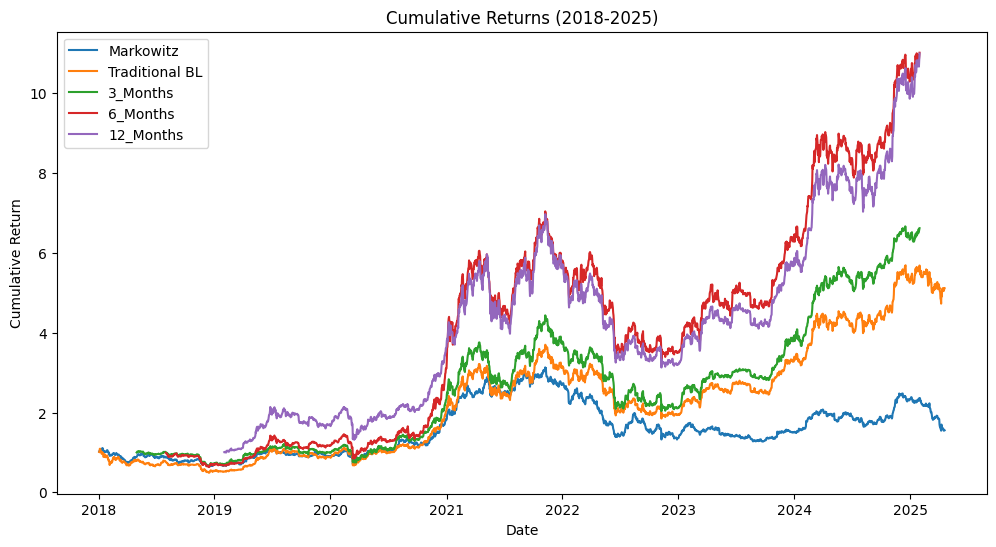

In [19]:
# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Markowitz'] = (1 + returns_portfolio_3).cumprod()
cumulative_returns_weighted['Traditional BL'] = (1 + returns_portfolio1).cumprod()
cumulative_returns_weighted['3_Months'] = (1 + combined_df2).cumprod()
# cumulative_returns_weighted['4_Months'] = (1 + combined_df3).cumprod()
# cumulative_returns_weighted['5_Months'] = (1 + combined_df4).cumprod()
cumulative_returns_weighted['6_Months'] = (1 + combined_df5).cumprod()
cumulative_returns_weighted['12_Months'] = (1 + combined_df6).cumprod()


# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

After we received results from each portfolios, we plotted their cumulative returns from 2018 to 2025 to evaluateperformance.

As shown in the chart:



*   The top 2 performing portfolios are those with 6 months and 12 months rebalancing strategies.
*   While, the Markowitz portfolio received the lowest cumulative return over the period.

This suggests that with the Black-litterman intregated with models and rebalancing every 6 months, or 12 months can lead to better performance


# **Compare Across 4 metrics: Annualized Return, Sharpe Ratio, Sortino Ratio, Maximum Drawdown**


*   **Annualized Returns**

This is a metric used to evaluate the performance of an investment over a specific period, on the assumption that the investment has grown at a constant rate each year

$$
R_A = \left( \frac{PV}{PV_0} \right)^{\frac{1}{t}} - 1
$$


* **Sharpe ratio**

Sharpe ratio is a metric used to evaluate the performance of an investment by comparing its return to the level of risk taken. It expresses the idea that higher returns may simply reflect greater volatility, not necessarily better investment decisions

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

where Rp – portfolio return, Rf – risk-free return, σp - Volatility measured as the standard deviation of returns


* **Sortino ratio**

Sortino ratio is focusing on downside risk.  Sortino ratio helps us to evaluate downside risk.  

$$
\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}
$$

where Rp – portfolio return, Rf – risk-free return, σd - Volatility measured as the standard deviation of downside returns



* **Maximum Drawdown**

Maximum Drawdown measures the largest decline in a portfolio's value from its highest point (peak) to its lowest point (trough) before a new peak is reached.

$$
\text{MaxDD} = \max \left( \frac{\text{Peak} - \text{Trough}}{\text{Peak}} \right)
$$


where  Peak – maximum realized portfolio value over the investment period, Trough – minimum realized portfolio value over the investment period

In [24]:
# annualized_volatility_weighted = {}
sharpe_ratio_weighted = {}
max_drawdown_weighted = {}
sortino_ratio_weighted = {}
annualized_return_weighted = {}


for name, returns in cumulative_returns_weighted.items():
    # Calculate daily returns from cumulative returns
    daily_returns = returns.pct_change().dropna()

    # # Annualized volatility
    # vol = daily_returns.std() * np.sqrt(52)
    # annualized_volatility_weighted[name] = vol

    # Sharpe Ratio (assuming risk-free rate = 0)
    sr = (daily_returns.mean() * 52) / vol
    sharpe_ratio_weighted[name] = sr

    # Sortino Ratio
    downside_returns = daily_returns[daily_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(52)
    mean_return = daily_returns.mean() * 52
    sortino_ratio = mean_return / downside_std if downside_std != 0 else np.nan
    sortino_ratio_weighted[name] = sortino_ratio

    # Maximum Drawdown
    running_max = returns.cummax()
    drawdown = (returns / running_max) - 1
    max_drawdown = drawdown.min()
    max_drawdown_weighted[name] = max_drawdown


    # Annualized Return (based on total return)
    total_return = returns.iloc[-1] / returns.iloc[0] - 1
    num_weeks = len(daily_returns)
    annualized_ret = (1 + total_return) ** (52 / num_weeks) - 1
    annualized_return_weighted[name] = annualized_ret

# Print out performance metrics
for name in cumulative_returns_weighted.keys():
    print(f"{name} Performance Metrics:")
    print(f"Annualized Return: {annualized_return_weighted[name]:.2%}")
    # print(f"Annualized Volatility: {annualized_volatility_weighted[name]:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio_weighted[name]:.2f}")
    print(f"Sortino Ratio: {sortino_ratio_weighted[name]:.2f}")
    print(f"Maximum Drawdown: {max_drawdown_weighted[name]:.2%}")
    print("\n")

Markowitz Performance Metrics:
Annualized Return: 0.81%
Sharpe Ratio: 0.11
Sortino Ratio: 0.18
Maximum Drawdown: -59.37%


Traditional BL Performance Metrics:
Annualized Return: 3.22%
Sharpe Ratio: 0.29
Sortino Ratio: 0.38
Maximum Drawdown: -55.14%


3_Months Performance Metrics:
Annualized Return: 4.14%
Sharpe Ratio: 0.35
Sortino Ratio: 0.47
Maximum Drawdown: -54.18%


6_Months Performance Metrics:
Annualized Return: 5.46%
Sharpe Ratio: 0.45
Sortino Ratio: 0.56
Maximum Drawdown: -52.67%


12_Months Performance Metrics:
Annualized Return: 5.86%
Sharpe Ratio: 0.47
Sortino Ratio: 0.62
Maximum Drawdown: -55.14%




In [29]:
performance_data = {
    "Annualized Return": annualized_return_weighted,
    "Sharpe Ratio": sharpe_ratio_weighted,
    "Sortino Ratio": sortino_ratio_weighted,
    "Max Drawdown": max_drawdown_weighted,
}

# Convert to DataFrame
performance_df = pd.DataFrame(performance_data)

# Format to 2 decimal places
performance_df = performance_df.applymap(lambda x: f"{x:.2%}" if isinstance(x, float) else x)

# Display the table
display(performance_df)

<ipython-input-29-ab9f661f2024>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  performance_df = performance_df.applymap(lambda x: f"{x:.2%}" if isinstance(x, float) else x)


,Annualized Return,Sharpe Ratio,Sortino Ratio,Max Drawdown
Markowitz,0.81%,11.36%,17.52%,-59.37%
Traditional BL,3.22%,29.33%,38.16%,-55.14%
3_Months,4.14%,34.80%,47.02%,-54.18%
6_Months,5.46%,45.28%,55.75%,-52.67%
12_Months,5.86%,47.24%,62.07%,-55.14%


The results from our backtesting demonstrate that integrating Machine Learning and Deep learning models with Black-Litterman is significantly enhances portfolio performance across all evaluation metrics.

Key findings:


**Markowitz** had the lowest performance with smallest Sharpe Ratio, Highest maximum drawdown, and lowest cumulative return.

**Black-Litterman** model had better performance than Morkowitz across 4 metrics

**ML/DL models integrated with Black-Litterman** significantly outperformed traditional

Performance of the 6_month and 12_month rebalancing strategies is quite close

6_month model has a Sharpe Ratio of 0.45 and a Sortino Ratio of 0.56, while the 12_month model slightly better ahead with a Sharpe of 0.47 and Sortino of 0.62. However, the 6_month strategy has a smaller maximum drawdown at -52.67% compared to -55.14% for the 12_month.

